# Lexical Analysis

In [1]:
import sagemaker
sess = sagemaker.Session()
bucket = sess.default_bucket()
# !aws s3 ls s3://{bucket}/project/submissions/ --recursive

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# Setup - Run only once per Kernel App
%conda install https://anaconda.org/conda-forge/openjdk/11.0.1/download/linux-64/openjdk-11.0.1-hacce0ff_1021.tar.bz2

# install PySpark
%pip install pyspark==3.4.0

# install seaborn
%pip install seaborn

%pip install wordcloud

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")




## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - conda-forge/openjdk/11.0.1/download/linux-64::openjdk==11.0.1=hacce0ff_1021


The following NEW packages will be INSTALLED:

  openjdk            conda-forge/openjdk/11.0.1/download/linux-64::openjdk-11.0.1-hacce0ff_1021 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (547 kB)
Note: you may need to resta

In [3]:
!pip install spark-nlp==5.5.0

  Using cached spark_nlp-5.5.0-py2.py3-none-any.whl.metadata (19 kB)
Using cached spark_nlp-5.5.0-py2.py3-none-any.whl (620 kB)


In [4]:
from pyspark.sql import SparkSession
import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","32G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/sagemaker-user/.ivy2/cache
The jars for the packages stored in: /home/sagemaker-user/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-87e48e85-3f86-4793-82f9-967cd4f571ee;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.go

3.4.0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

In [6]:
submissions_sentiment = spark.read.parquet(f"s3a://{bucket}/project/submissions_sentiments/*.parquet", header=True).cache()

24/12/12 05:57:29 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
submissions_sentiment = submissions_sentiment.repartition(64)
subreddits = ['Conservative', 'Republican', 'democrats', 'Liberal', 'Libertarian', 'politics']
submissions_sentiment = submissions_sentiment.filter(submissions_sentiment['subreddit'].isin(subreddits))
submission_count = submissions_sentiment.groupBy("subreddit").count().collect()
count = {row['subreddit']: row['count'] for row in submission_count}

## Count Vectorization

In [8]:
from pyspark.ml.feature import CountVectorizer

# DocumentAssembler from Spark NLP to process text
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

# Tokenizer for breaking text into words
tokenizer = sparknlp.annotator.Tokenizer().setInputCols(["document"]).setOutputCol("tokens")

# stemmer = Stemmer() \
#     .setInputCols(["tokens"]) \
#     .setOutputCol("stemmed")

# lemmatizer = LemmatizerModel.pretrained() \
#     .setInputCols(["stemmed"]) \
#     .setOutputCol("lemmatized")

normalizer = Normalizer() \
    .setInputCols(["tokens"]) \
    .setOutputCol("normalized")

custom_stopwords = ["trump", "biden", "trump’s", "trumps", "bidens", "biden's", "like", "s",
                    "t", "joe", "donald", "says","president","election","www","com","https",
                    "new","libertarian","green","m","people","party","think", "time", "going", 
                    "gop","said", "d", "u","old","don","know","admin","e","ly","j","b"]

# custom_stopwords = ["trump", "biden", "trump’s", "trumps", "bidens", "biden's", "like", "s",
#                     "t", "joe", "donald", "says","president","election","www","com","https",
#                     "new","libertarian","green","m","people","party","think", "time", "going", 
#                     "gop","said", "d", "u","old","don","know","admin","court", "case", "house", 
#                     "trial","good", "debate", "vote","campaign","supreme","country","democrats",
#                     "republicans","politics","republican"]

ss = StopWordsCleaner().pretrained("stopwords_iso", "en")
stop_words = ss.getStopWords() + custom_stopwords

# Set the updated list of stopwords
stopwords_cleaner = StopWordsCleaner().setStopWords(stop_words).setInputCols(["normalized"]).setOutputCol("cleaned")
# stopwords_cleaner = StopWordsCleaner().setStopWords(stop_words).setInputCols(["lemmatized"]).setOutputCol("cleaned")

finisher = Finisher().setInputCols(["cleaned"]).setOutputCols(["finished_cleaned"])

count_vectorizer = CountVectorizer().setInputCol("finished_cleaned").setOutputCol("features")

# Define stages for the pipeline
stages = [
    document_assembler,
    tokenizer,
    # stemmer,
    # lemmatizer,
    normalizer,
    stopwords_cleaner,
    finisher,
    count_vectorizer
]

# Add the pipeline stages to the pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline
model = pipeline.fit(submissions_sentiment)
df_transformed = model.transform(submissions_sentiment)

stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[ / ]stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
Download done! Loading the resource.
[OK!]


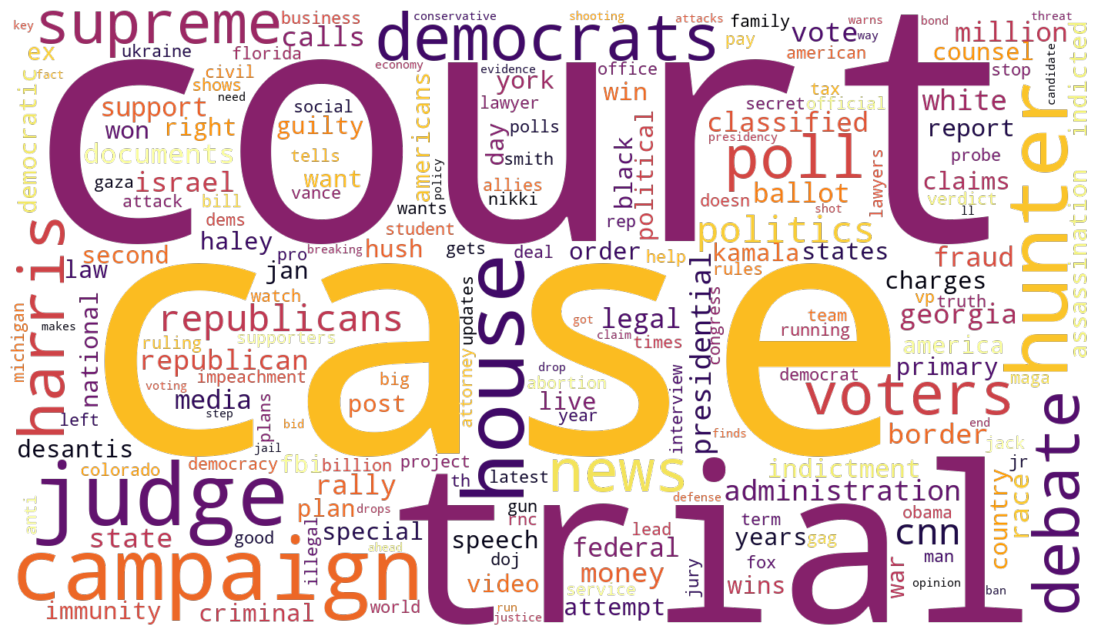

In [9]:
from collections import Counter
from wordcloud import WordCloud

# Aggregate all lists into one using collect_list and explode
result = df_transformed.select(F.explode(F.col("finished_cleaned"))).groupBy().agg(F.collect_list("col").alias("merged_list"))

merged_list = result.collect()[0]['merged_list']
words_freq = Counter(merged_list)

# Create a Wordcloud
wordcloud = WordCloud(width=1400, height=800, collocations=False, colormap='inferno', background_color=None, mode='RGBA').generate_from_frequencies(words_freq)

plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.savefig("../../website-source/plots/word_cloud.png", format="png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

## CV for each subreddit

In [11]:
# DocumentAssembler from Spark NLP to process text
document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

# Tokenizer for breaking text into words
tokenizer = sparknlp.annotator.Tokenizer().setInputCols(["document"]).setOutputCol("tokens")

normalizer = Normalizer() \
    .setInputCols(["tokens"]) \
    .setOutputCol("normalized")

custom_stopwords = ["trump", "biden", "trump’s", "trumps", "bidens", "biden's", "like", "s",
                    "t", "joe", "donald", "says","president","election","www","com","https",
                    "new","libertarian","green","m","people","party","think", "time", "going", 
                    "gop","said", "d", "u","old","don","know","admin","court", "case", "house", 
                    "trial","good", "debate", "vote","campaign","supreme","country","democrats",
                    "republicans","politics","republican","judge","e","ly"]

ss = StopWordsCleaner().pretrained("stopwords_iso", "en")
stop_words = ss.getStopWords() + custom_stopwords

# Set the updated list of stopwords
stopwords_cleaner = StopWordsCleaner().setStopWords(stop_words).setInputCols(["normalized"]).setOutputCol("cleaned")

finisher = Finisher().setInputCols(["cleaned"]).setOutputCols(["finished_cleaned"])

count_vectorizer = CountVectorizer().setInputCol("finished_cleaned").setOutputCol("features")

# Define stages for the pipeline
stages = [
    document_assembler,
    tokenizer,
    normalizer,
    stopwords_cleaner,
    finisher,
    count_vectorizer
]

# Add the pipeline stages to the pipeline
sub_pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline
sub_model = sub_pipeline.fit(submissions_sentiment)
sub_df_transformed = sub_model.transform(submissions_sentiment)

stopwords_iso download started this may take some time.
Approximate size to download 2.1 KB
[OK!]


In [12]:
from pyspark.ml.linalg import SparseVector
from functools import reduce

subreddits = ['Conservative', 'Republican', 'democrats', 'Liberal', 'Libertarian', 'politics']

# Function to convert SparseVector to dictionary
def sparse_vector_to_dict(sparse_vector):
    return dict(zip(sparse_vector.indices, sparse_vector.values))

# Function to sum two dictionaries
def sum_dicts(a, b):
    # Combine the dictionaries, summing the values of common keys
    return {key: a.get(key, 0) + b.get(key, 0) for key in set(a) | set(b)}

# Function to process each row and convert SparseVector to dictionary
def process_row(row):
    sparse_vector = row['features']
    return sparse_vector_to_dict(sparse_vector)

words_counts = {}
for subreddit in subreddits:
    print(subreddit)
    # Filter submissions for the current subreddit
    sub_data = submissions_sentiment.filter(submissions_sentiment['subreddit'] == subreddit)
    
    # Fit the pipeline and transform the data
    sub_model = sub_pipeline.fit(sub_data)
    transformed_data = sub_model.transform(sub_data)

    # Extract the CountVectorizer model from the pipeline
    cv_model = sub_model.stages[-1]
    vocab = cv_model.vocabulary
    
    # Map the rows to dictionaries
    mapped_result = transformed_data.rdd.map(process_row).collect()
    
    # Now sum up all the dictionaries using reduce
    combined_dict = reduce(sum_dicts, mapped_result)

    final_dict = dict(zip(vocab, combined_dict.values()))
    
    words_counts[subreddit] = final_dict

Conservative


Republican


democrats


Liberal


Libertarian


politics


## Topic Modeling

In [13]:
from pyspark.ml.clustering import LDA

lda = LDA(k=5, maxIter=20, featuresCol="features", seed=6001)

# Extract the CountVectorizer model from the pipeline
cv_model = model.stages[-1]
vocab = cv_model.vocabulary

# Fit the LDA model
lda_model = lda.fit(df_transformed)

# Get topics from the LDA model
topics = lda_model.describeTopics()

# Map the topics to words
overal_topics_with_words = topics.rdd.map(
    lambda row: [vocab[idx] for idx in row['termIndices']]
).collect()

## LDA for each subreddit

In [14]:
subreddits = ['Conservative', 'Republican', 'democrats', 'Liberal', 'Libertarian', 'politics']
lda = LDA(k=5, maxIter=20, featuresCol="features")
topics_dict = {}

# Loop through each subreddit
for subreddit in subreddits:
    print(subreddit)
    # Filter submissions for the current subreddit
    sub_data = submissions_sentiment.filter(submissions_sentiment['subreddit'] == subreddit)
    
    # Fit the pipeline and transform the data
    sub_model = sub_pipeline.fit(sub_data)
    transformed_data = sub_model.transform(sub_data)

    # Extract the CountVectorizer model from the pipeline
    cv_model = sub_model.stages[-1]
    vocab = cv_model.vocabulary

    # Fit the LDA model
    lda_model = lda.fit(transformed_data)

    # Get topics from the LDA model
    topics = lda_model.describeTopics()

    # Map the topics to words
    topics_with_words = topics.rdd.map(
        lambda row: [vocab[idx] for idx in row['termIndices']]
    ).collect()

    topics_dict[subreddit] = topics_with_words

Conservative


Republican


democrats


Liberal


Libertarian


politics


In [42]:
subreddits = ['Conservative', 'Republican', 'democrats', 'Liberal', 'Libertarian', 'politics']
k = 10

top_words_dict = {}
for s in subreddits:
    top_k_words = [i[0] for i in list(words_counts[s].items())][:k]
    top_k_percentage = [round(i[1]/count[s]*100,2) for i in list(words_counts[s].items())[:k]]
    word_count_list = []
    for i in range(k):
        word_count_list.append(str(top_k_words[i]) + " (" + str(top_k_percentage[i]) + "%)")
    top_words_dict[s] = word_count_list

df = pd.DataFrame(top_words_dict)
df.to_csv("../../data/tables/top_words.csv")
df

,Conservative,Republican,democrats,Liberal,Libertarian,politics
0,hunter (6.08%),hunter (8.07%),harris (3.87%),news (4.73%),convention (6.6%),harris (2.88%)
1,border (2.67%),border (3.9%),voters (3.71%),voters (4.64%),israel (6.24%),poll (2.6%)
2,white (2.31%),report (2.51%),administration (3.34%),right (4.17%),war (4.81%),cnn (2.58%)
3,poll (2.14%),fbi (2.13%),news (3.03%),win (4.08%),right (4.28%),documents (2.47%)
4,administration (2.05%),white (2.07%),state (2.92%),democracy (3.8%),administration (4.1%),georgia (2.47%)
5,media (2.02%),news (2.06%),million (2.44%),voting (3.53%),want (3.92%),money (2.41%)
6,news (2.0%),doj (2.0%),white (2.14%),support (3.53%),hunter (3.92%),voters (2.41%)
7,voters (1.9%),illegal (1.94%),federal (2.11%),wins (3.43%),support (3.74%),presidential (2.41%)
8,state (1.89%),poll (1.82%),states (2.07%),want (3.43%),crimes (3.57%),news (2.4%)
9,report (1.85%),rally (1.73%),support (2.04%),legal (3.34%),billion (3.21%),classified (2.29%)


In [24]:
topic_words_dict = {}
for i, topic in enumerate(overal_topics_with_words, 1):
    topic_words_dict[f"Topic {i}"] = topic
    
df = pd.DataFrame(topic_words_dict)
df.to_csv("../../data/tables/topic_words.csv")
df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,case,lies,israel,border,court
1,judge,coming,rally,texas,campaign
2,hunter,warns,trial,crisis,democrats
3,trial,country,guilty,administration,house
4,documents,heard,war,wall,voters
5,classified,death,money,illegal,debate
6,special,covid,ukraine,mexico,poll
7,order,house,live,indictments,supreme
8,money,netanyahu,shot,migrant,harris
9,fbi,epstein,hamas,executive,news


### Google Trends

In [26]:
import re
import ast
biden_trends = pd.read_csv("../../data/csv/biden_trends.csv")
trump_trends = pd.read_csv("../../data/csv/trump_trends.csv")

biden_trends["topics"] = biden_trends["topics"].apply(ast.literal_eval)
biden_trends["queries"] = biden_trends["queries"].apply(ast.literal_eval)
biden_trends["trends"] = biden_trends["topics"] + biden_trends["queries"]

trump_trends["topics"] = trump_trends["topics"].apply(ast.literal_eval)
trump_trends["queries"] = trump_trends["queries"].apply(ast.literal_eval)
trump_trends["trends"] = trump_trends["topics"] + trump_trends["queries"]

# Custom stop words to remove
custom_stop_words = ['biden', 'joe', 'trump', 'donald', 'the', 'of', 'in', 'out', 'states', 'state', 'new', 'did', 'on', 'day']

def google_trends_topics(df, n):
    data = [item for sublist in df["trends"] for item in sublist]
    
    words = []
    for item in data:
        # Tokenize and convert to lowercase
        item_words = re.findall(r'\b\w+\b', item.lower())
        # Remove custom stop words
        item_words = [word for word in item_words if word not in custom_stop_words]
        words.extend(item_words)

    count = len(words)
    word_counts = Counter(words)
    
    top_common_words = word_counts.most_common(n)
    return top_common_words, count

google_trends_trump, t_count = google_trends_topics(trump_trends, 20)
google_trends_biden, b_count = google_trends_topics(biden_trends, 20)

In [27]:
trump_trending_words = []
for i in google_trends_trump:
    trump_trending_words.append(i[0])

biden_trending_words = []
for i in google_trends_trump:
    biden_trending_words.append(i[0])

In [28]:
from itertools import islice

k = 10
google_trends_dict = {"Trump": [], "Biden": []}

for i in islice(zip(google_trends_trump, google_trends_biden), k):
    google_trends_dict["Trump"].append(str(i[0][0]) + " (" + str(i[0][1]) + ")")
    google_trends_dict["Biden"].append(str(i[1][0]) + " (" + str(i[1][1]) + ")")

df = pd.DataFrame(google_trends_dict)
df.to_csv("../../data/tables/google_trends_words.csv")
df

,Trump,Biden
0,debate (22),hunter (25)
1,united (17),united (18)
2,court (17),israel (13)
3,media (15),debate (13)
4,shot (14),impeachment (12)
5,trial (14),speech (10)
6,indictment (12),jill (10)
7,speaker (12),house (9)
8,mug (11),conference (9)
9,house (11),union (9)


In [214]:
# output_path = f"s3a://{bucket}/project/pipelined_submissions"
# df_transformed.write.mode("overwrite").parquet(output_path)